In [2]:
import os
import cv2
import numpy as np

import torch
from torch.utils.data import DataLoader, Dataset
from torch.nn import Module, Conv2d, ConvTranspose2d, MaxPool2d, ReLU, Sigmoid, Sequential, ModuleList, BatchNorm2d
from torch.optim import AdamW

from torchvision.io import decode_image

from utils.masking import mask_image
from utils.notebook import imshow
from utils.tensor import numpy_to_tensor, tensor_to_numpy


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device.type

'cuda'

In [3]:
class UNet(Module):
    def __init__(self):
        super(UNet, self).__init__()

        # encoder
        self.conv1 = Conv2d(3, 64, kernel_size=3, padding="same")
        self.conv2 = Conv2d(64, 64, kernel_size=3, padding="same")
        self.pool1 = MaxPool2d(kernel_size=2)
        self.conv3 = Conv2d(64, 128, kernel_size=3, padding="same")
        self.conv4 = Conv2d(128, 128, kernel_size=3, padding="same")
        self.pool2 = MaxPool2d(kernel_size=2)
        self.conv5 = Conv2d(128, 256, kernel_size=3, padding="same")
        self.conv6 = Conv2d(256, 256, kernel_size=3, padding="same")
        self.pool3 = MaxPool2d(kernel_size=2)
        self.conv7 = Conv2d(256, 512, kernel_size=3, padding="same")
        self.conv8 = Conv2d(512, 512, kernel_size=3, padding="same")
        self.pool4 = MaxPool2d(kernel_size=2)

        # bottleneck
        self.conv9 = Conv2d(512, 1024, kernel_size=3, padding="same")
        self.conv10 = Conv2d(1024, 1024, kernel_size=3, padding="same")

        # decoder
        self.upconv1 = ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.conv11 = Conv2d(1024, 512, kernel_size=3, padding="same")
        self.conv12 = Conv2d(512, 512, kernel_size=3, padding="same")
        self.upconv2 = ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.conv13 = Conv2d(512, 256, kernel_size=3, padding="same")
        self.conv14 = Conv2d(256, 256, kernel_size=3, padding="same")
        self.upconv3 = ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.conv15 = Conv2d(256, 128, kernel_size=3, padding="same")
        self.conv16 = Conv2d(128, 128, kernel_size=3, padding="same")
        self.upconv4 = ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.conv17 = Conv2d(128, 64, kernel_size=3, padding="same")
        self.conv18 = Conv2d(64, 64, kernel_size=3, padding="same")
        self.conv19 = Conv2d(64, 3, kernel_size=1)

        self.relu = ReLU()
        self.sigmoid = Sigmoid()

    def forward(self, x):
        # encoder
        x = self.relu(self.conv1(x))
        skip4 = self.relu(self.conv2(x))
        x = self.pool1(skip4)
        
        x = self.relu(self.conv3(x))
        skip3 = self.relu(self.conv4(x))
        x = self.pool2(skip3)
        
        x = self.relu(self.conv5(x))
        skip2 = self.relu(self.conv6(x))
        x = self.pool3(skip2)

        x = self.relu(self.conv7(x))
        skip1 = self.relu(self.conv8(x))
        x = self.pool4(skip1)

        # bottleneck
        x = self.relu(self.conv9(x))
        x = self.relu(self.conv10(x))

        # decoder
        x = self.upconv1(x)
        x = torch.cat((x, skip1), dim=1)
        x = self.relu(self.conv11(x))
        x = self.relu(self.conv12(x))

        x = self.upconv2(x)
        x = torch.cat((x, skip2), dim=1)
        x = self.relu(self.conv13(x))
        x = self.relu(self.conv14(x))

        x = self.upconv3(x)
        x = torch.cat((x, skip3), dim=1)
        x = self.relu(self.conv15(x))
        x = self.relu(self.conv16(x))

        x = self.upconv4(x)
        x = torch.cat((x, skip4), dim=1)
        x = self.relu(self.conv17(x))
        x = self.relu(self.conv18(x))
        x = self.sigmoid(self.conv19(x))

        return x

In [4]:
model = UNet().to(device)
model

UNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv6): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv7): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv8): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv9): Conv2d(512, 1024, kernel_size

In [5]:
img = cv2.imread('../.images/test_256/Places365_test_00003209.jpg')
assert img is not None, "Image not found"

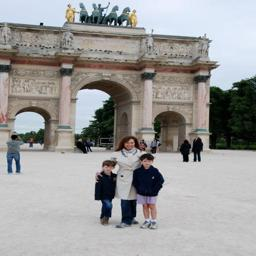

In [6]:
imshow(img)

(256, 256, 3)


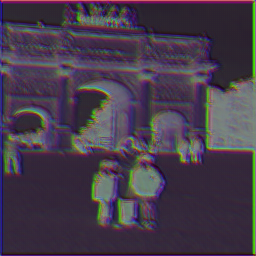

In [ ]:
model.eval()
with torch.no_grad():
    tensor = numpy_to_tensor(img).unsqueeze(0).to(device)
    output = model(tensor)
    result = tensor_to_numpy((output*255).squeeze(0))
imshow(result)

In [17]:
class ImageDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.img_names = os.listdir(img_dir)
    
    def __len__(self):
        return len(self.img_names)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_names[idx])
        img = decode_image(img_path)
        if self.transform:
            img = self.transform(img)
        return img
    
    def show_image(self, idx):
        img = self.__getitem__(idx)
        img_np = tensor_to_numpy(img)
        img_np[:, :, [0, 1, 2]] = img_np[:, :, [2, 1, 0]] # convert RGB to BGR
        imshow(img_np)

In [18]:
train_dataset = ImageDataset('../.images/test_256')

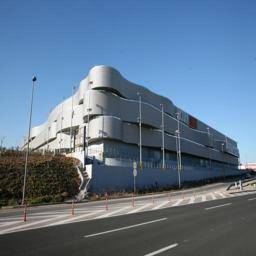

In [19]:
train_dataset.show_image(0)